In [5]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","IterTools","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data, gpu
using Plots; default(fmt=:png,ls=:auto)

In [16]:
using AutoGrad: full
using LinearAlgebra
using Knet
include("../src/optimizer.jl")
include("../src/helperfunctions.jl")

_accumulator_updater (generic function with 1 method)

In [7]:
# Load data (see mnist.ipynb)
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata();              # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

In [19]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takenth(progress(sgd(model,ncycle(dtrn,100))),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [9]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [10]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [11]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [12]:
lenet =   Chain(Conv(5,5,1,20), 
                Conv(5,5,20,50), 
                Dense(800,500,pdrop=0.3), 
                Dense(500,10,identity,pdrop=0.3))
summary.(l.w for l in lenet.layers)

4-element Array{String,1}:
 "5×5×1×20 AutoGrad.Param{KnetArray{Float32,4}}" 
 "5×5×20×50 AutoGrad.Param{KnetArray{Float32,4}}"
 "500×800 AutoGrad.Param{KnetArray{Float32,2}}"  
 "10×500 AutoGrad.Param{KnetArray{Float32,2}}"   

In [17]:
sm3_results = trainresults("sm3113.jld2",lenet);
# sm3_results = Knet.load("sm3113.jld2", "results");

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 04:15/04:15, 235.41i/s] 


Float32[0.07795503; 0.07058454; 0.02345; 0.022]


In [20]:
sgd_results = trainresults("sgd113.jld2", lenet);
# sgd_results = Knet.load("sgd113.jld2", "results")

Train from scratch? stdin> y


┣████████████████████┫ [100.00%, 60000/60000, 04:09/04:09, 240.64i/s] 


Float32[0.059805088; 0.053912867; 0.01815; 0.018]


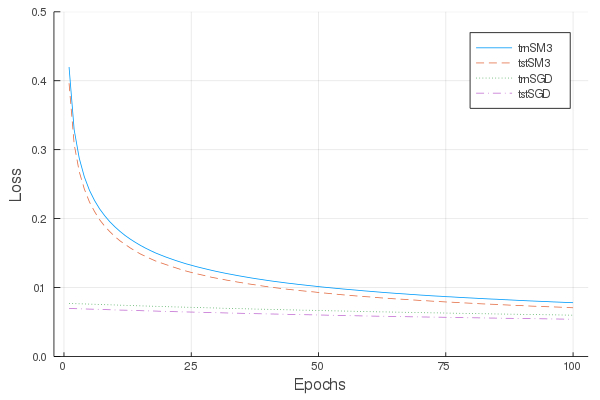

In [21]:
plot([sm3_results[1,:], sm3_results[2,:], sgd_results[1,:], sgd_results[2,:]],ylim=(0.0,0.5),
     labels=[:trnSM3 :tstSM3 :trnSGD :tstSGD],xlabel="Epochs",ylabel="Loss")